# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [11]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
# import modelproject
from OLGModel import OLGModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

Our model extends on the traditional OLG model with a government by introducing the possibility for agents to either consume their entire savings in period 2 or to transfers some of their savings to the next generation as a bequest. This increases the complexity for the model, as agents now has to optimize both for their optimal savings rate but also for the optimal level of bequests.

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Population is constant. A life consists of
two periods, *young* and *old*.

**Households:** As young a household supplies labor exogenously, $L_{t}=1$, and earns a after tax wage $(1-\tau_w)w_{t}$. Consumption as young and old
are denoted by $C_{1t}$ and $C_{2t+1}$. The after-tax return on saving is $(1-\tau_{r})r_{t+1}$. Utility is
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1],\chi_{t+1}}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta(\frac{C_{2t+1}^{1-\sigma}}{1-\sigma} + \frac{\chi_{t+1}^{1-\nu}}{1-\nu}),\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}((1-\tau_{w})w_{t}+\Gamma_t)\\
 & C_{1t}=(1-s_{t})((1-\tau_{w})w_{t}+ \Gamma_t)\\
 & \chi_{t+1} + C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$
    
The problem is formulated in terms of the saving rate $s_t\in[0,1]$ and the bequest $\chi_{t+1}$. The bequest recived follows the law-of-motion below

$$
\begin{aligned}
\Gamma_t = (1+(1-\tau_{\chi})r_{t-1})\chi_{t-1}
\end{aligned}
$$



The law-of-motion for the bequest is simply the bequest saved by the agents in last period corrected by the post-tax return. Therefore, we assume that the bequest can be renumerated by the same interest rates as savings. An interesting feature of the modifications, is that we allow for different tax-rates between bequests and savings.

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$,
and hires labor $E_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}=F(K_{t-1},E_{t})=(\alpha K_{t-1}^{-\theta}+(1-\alpha)E_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    
Profits are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}E_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** Choose public consumption, $G_{t}$, and tax rates $\tau_w \in [0,1]$ and $\tau_r \in [0,1]$. Total tax revenue is
    
$$
\begin{aligned}
T_{t} &=\tau_r r_{t} (K_{t-1}+B_{t-1})+\tau_w w_{t}   
\end{aligned}
$$
    
Government debt accumulates according to
    
$$
\begin{aligned}
B_{t} &=(1+r^b_{t})B_{t-1}-T_{t}+G_{t} 
\end{aligned}
$$
       
A *balanced budget* implies $G_{t}=T_{t}-r_{t}B_{t-1}$.

**Capital:** Depreciates with a rate of $\delta \in [0,1]$.

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. No-arbitrage between bonds and capital

    $$
    r_{t}=r_{t}^{K}-\delta=r_{t}^{b}
    $$

4. Labor market clears: $E_{t}=L_{t}=1$
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+G_{t}+I_{t}$
6. Asset market clears: $S_{t}=K_{t}+B_{t}+ \chi_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

## Analytical solution

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & =F_{K}(K_{t-1},E_{t})=\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{E}(K_{t-1},E_{t})=(1-\alpha)E_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization:** From FOC

$$
\begin{aligned}
C_{1t}^{-\sigma} &= \beta (1+(1-\tau_r)r_{t+1})C_{2t+1}^{-\sigma}\\
C_{1t}^{-\sigma} &= \beta (1+(1-\tau_r)r_{t+1})\chi_{t+1}^{-\nu}
\end{aligned}
$$

This in turn implies

$$
\begin{aligned}
\chi_{t+1} &= C_{2t+1}^\frac{\sigma}{\nu}
\end{aligned}
$$

**Simulation algorithm:** At the beginning of period $t$, the
economy can be summarized in the state variables $K_{t-1}$ and $B_{t-1}$.  *Before* $s_t$ is known, we can calculate:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},1)\\
r_{t}^{k} & =F_{K}(K_{t-1},1)\\
w_{t} & =F_{E}(K_{t-1},1)\\
r_{t} & =r^k_{t}-\delta\\
r_{t}^{b} & =r_{t}\\
\tilde{r}_{t} & =(1-\tau_{r})r_{t}\\
C_{2t} & =(1+\tilde{r}_{t})(K_{t-1}+B_{t-1})\\
T_{t} & =\tau_{r}r_{t}(K_{t-1}+B_{t-1}-(1+r_t)\chi_{t-1})+\tau_{w}w_{t} +\tau_{\chi}r_t\chi_{t-1} \\
B_{t} & =(1+r^b_{t})B_{t-1}+T_{t}-G_{t}\\
\end{aligned}
$$

*After* $s_t$ is known we can calculate:

$$
\begin{aligned}
C_{1t} & = (1-s_{t})(1-\tau_{w})w_{t}\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}-G_{t}+\chi_t\\
K_{t} & =(1-\delta)K_{t-1} + I_t \\
\Gamma_t &= (1+(1-\tau_{\chi})r_{t-1})\chi_{t-1}
\end{aligned}
$$

**Solution algorithm:** Simulate forward choosing $s_{t}$ so
that we always have

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

## Numerical solution

In [88]:
from OLGModel import simulate_before_s, simulate_after_s, find_s_bracket, calc_euler_error

model = OLGModelClass()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

# a. production
par.production_function = 'cobb-douglas'
par.theta = 0.0

# b. households
par.sigma = 2.0

# c. government
par.tau_w = 0.0
par.tau_r = 0.0
sim.balanced_budget[:] = True # G changes to achieve this

# d. initial values
K_ss = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha))
par.K_lag_ini = 0.1*K_ss

initializing the model:
calling .setup()
calling .allocate()


In [89]:
model.simulate()

simulation done in 0.05 secs


In [58]:
K_lag_old = model.sim.K_lag.copy()

K_ss_model1 = sim.K_lag[-1]
B_ss = sim.B_lag[-1]
G_ss = sim.G[-1]
chi_SS = sim.chi[-1]

You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

In [8]:
for t in range(5):

    LHS_Euler = sim.C1[t]**(-par.sigma)
    RHS_Euler = (1+sim.rt[t+1])*par.beta * sim.C2[t+1]**(-par.sigma)
    
    print(f't = {t:2d}: euler-error = {LHS_Euler-RHS_Euler:.8f}')
    
    LHS_Euler2 = sim.C2[t] + sim.chi[t]
    RHS_Euler2 = (1+sim.rt[t])*(sim.K_lag[t]+sim.B_lag[t])
    print(f't = {t:2d}: euler-error 2 = {LHS_Euler2-RHS_Euler2:.8f}')           

t =  0: euler-error = -0.00000000
t =  0: euler-error 2 = 0.00000000
t =  1: euler-error = -0.00000000
t =  1: euler-error 2 = 0.00000000
t =  2: euler-error = 0.00000000
t =  2: euler-error 2 = 0.00000000
t =  3: euler-error = -0.00000000
t =  3: euler-error 2 = 0.00000000
t =  4: euler-error = -0.00000000
t =  4: euler-error 2 = 0.00000000


As we can see above both our Euler equation 1 and 2 converges. The first euler equation is from the standard OLG framework, whereas the second euler equation ensures that other agents also opts for the optimal Bequest.

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

We check for convergence in the model for slightly different start parameter values, the convergence shouldnt change too much and the steady state should be the same

In [38]:
#New start parameters

par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

# a. production
par.production_function = 'cobb-douglas'
par.theta = 0.0

# b. households
par.sigma = 2

# c. government
par.tau_w = 0.001
par.tau_r = 0.5

sim.balanced_budget[:] = True # G changes to achieve this

# d. initial values
K_ss = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha))
par.K_lag_ini = 0.1*K_ss

#Simulate model
model.simulate()

simulation done in 0.05 secs


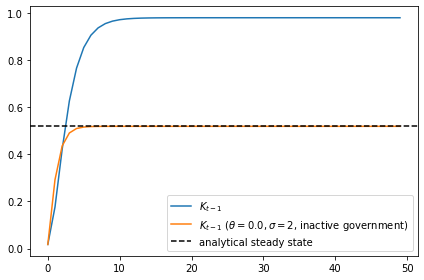

In [90]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.plot(K_lag_old,label=r'$K_{t-1}$ ($\theta = 0.0, \sigma = 2$, inactive government)')
ax.axhline(K_ss_model1,ls='--',color='black',label='analytical steady state')
ax.legend(frameon=True)
fig.tight_layout()

The converges look pretty neat for both cases.

## The heritage tax on bequest increases

In this section we will see how consumption and bequest changes in the second period of agents life, if the heritage tax for bequests increases.  

First, see how $\chi$ behaves in the baseline model:

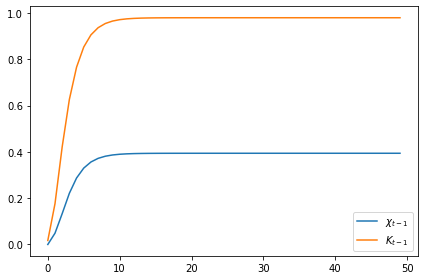

In [91]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.chi_lag,label=r'$\chi_{t-1}$')
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.legend(frameon=True)
fig.tight_layout()


Second, adjust the heritage rate for bequests:

In [85]:
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace


# c. government
par.tau_w = 0.001
par.tau_r = 0.0
par.tau_gamma = 0.0

sim.balanced_budget[:] = True # G changes to achieve this

# d. initial values
K_ss = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha))
par.K_lag_ini = 0.1*K_ss

model.simulate()

simulation done in 0.04 secs


Plot the new trends

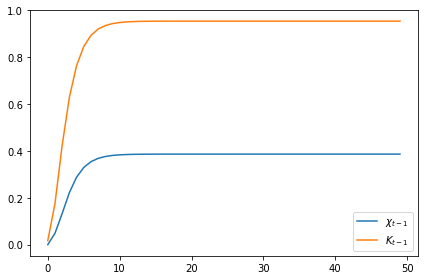

In [86]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.chi_lag,label=r'$\chi_{t-1}$')
ax.plot(model.sim.K_lag,label=r'$K_{t-1}$')
ax.legend(frameon=True)
fig.tight_layout()

# Conclusion

Add concise conclusion. 

To-do liste:

- Forklaring af model (Intution)
- Timeline af forløbet med arv
- Kode optimering, find optimal saving rate og arv rate
- Konklusion (Rasmus)
- Graf uden fleksibilitet
- 

